# Denoising Handwritten Digits

This project primarily aims to showcase the practical use of Autoencoders for denoising purposes. Our approach involves introducing Gaussian noise into the MNIST (Modified National Institute of Standards and Technology) dataset and subsequently attempting to remove this noise through the application of various filters such as Gaussian Filter, Bilateral Filter, and Median Filter. However, our main emphasis will be on exploring the effectiveness of **Stacked Sparse Autoencoders** in the context of denoising tasks.

### Importing Essential Tools

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from IPython.display import Image, display

In [3]:
from keras.datasets import mnist
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.regularizers import l1

### Functions

In [4]:
def normalise(img_arr):
    """
    Rescale pixels values to [0,1]
    """
    return img_arr.astype("float32")/255

def add_gnoise(img_arr, factor =0.3):
    """
    Add Gaussian Noise to the array.
    """
    noise = factor * np.random.normal(loc=0.0, scale=1.0, size=img_arr.shape)
    img_arr = img_arr + noise
    img_arr = np.clip(img_arr,0,1)
    return img_arr


def display(orig_arr,noisy_arr,enc_arr,dec_arr):
    """
    Display 5 images (28 x 28) from each of the provided arrays. 
    """
    rows = 4
    cols = 5
    
    fig, axis = plt.subplots(nrows=rows, ncols=cols, figsize=(5, 5))

    labels = ["Original", "Noisy", "Encoded", "Decoded"]
    arrays = [orig_arr, noisy_arr, enc_arr, dec_arr]

    for row in range(rows):
        for col in range(cols):
            plt.gray()
            axis[row, col].set_yticks([])
            axis[row, col].set_xticks([])
            if labels[row]=="Encoded":
                axis[row, col].imshow(arrays[row][col].reshape(8, 4)) # 32 dimensional encoded representation
            else:
                axis[row, col].imshow(arrays[row][col].reshape(28, 28))
            axis[row, col].set_title(labels[row])

    plt.show()

### Data Loading

In [5]:
((X_train,y_train),(X_test,y_test)) = mnist.load_data()

In [6]:
X_train.shape,y_train.shape

((60000, 28, 28), (60000,))

In [7]:
X_test.shape,y_test.shape

((10000, 28, 28), (10000,))

There are 70,000 images of handwritten digits in the MNIST dataset. Of these 70,000, 60,000 are being used for training and rest 10,000 for testing. Each image is a black and white image with pixel values ranging [0,255]. Each image is 28 x 28 pixels.

### Data Visualisation

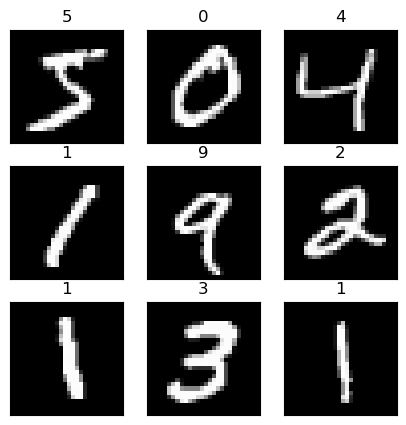

In [8]:
rows = 3
cols = 3
fig, axis = plt.subplots(nrows=rows,ncols=cols,figsize=(5,5))
plt.gray()
count = 0
for row in range(rows):
    for col in range(cols):
        axis[row][col].set_title(y_train[count])
        axis[row][col].imshow(X_train[count])
        axis[row][col].set_xticks([])
        axis[row][col].set_yticks([])
        count = count + 1

### Modelling Sparse Auto Encoder , Encoder and Decoder

In [9]:
INPUT = Input(shape=(28*28,))

enc1 = Dense(units=256,activation="relu",activity_regularizer=l1(10e-5))(INPUT)
enc2 = Dense(units=128,activation="relu",activity_regularizer=l1(10e-5))(enc1)
enc3 = Dense(units=64,activation="relu",activity_regularizer=l1(10e-5))(enc2)

encoded = Dense(units=32,activation="relu",activity_regularizer=l1(10e-5))(enc3)

dec1 = Dense(units=64,activation="relu",activity_regularizer=l1(10e-5))(encoded)
dec2 = Dense(units=128,activation="relu",activity_regularizer=l1(10e-5))(dec1)
dec3 = Dense(units=256,activation="relu",activity_regularizer=l1(10e-5))(dec2)

decoded = Dense(units=28*28, activation="sigmoid")(dec3)  # sigmoid activation, because i will scale image pixels to [0,1]

# Simple Sparse Stacked - Auto Encoder
autoencoder = Model(INPUT,decoded)

# Encoder
encoder = Model(INPUT, encoded)

# Decoder
ENCODED_INPUT = Input(shape=(32,))
deco1 = autoencoder.layers[-4](ENCODED_INPUT)
deco2 = autoencoder.layers[-3](deco1)
deco3 = autoencoder.layers[-2](deco2)
deco4 = autoencoder.layers[-1](deco3)

decoder = Model(ENCODED_INPUT,deco4)

In [10]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320  

In [11]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
Total params: 244192 (953.88 KB)
Trainable params: 244192 (953.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dense_7 (Dense)             (None, 784)               201488    
                                                                 
Total params: 244944 (956.81 KB)
Trainable params: 244944 (956.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Data Processing

In [13]:
NOISE_FACTOR = 0.5

pX_train = normalise(X_train)  # processed X_train
pX_test  = normalise(X_test)   # processed X_test

noisy_pX_train = add_gnoise(pX_train, NOISE_FACTOR)  # noisy processed X_train
noisy_pX_test  = add_gnoise(pX_test , NOISE_FACTOR)  # noisy processed X_test

In [14]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [15]:
pX_train.shape, pX_test.shape

((60000, 28, 28), (10000, 28, 28))

In [16]:
noisy_pX_train.shape, noisy_pX_test.shape

((60000, 28, 28), (10000, 28, 28))

### Compiling and Fitting

In [17]:
# Compile
autoencoder.compile(optimizer="adam",loss="binary_crossentropy",metrics=["mse"])

# Callbacks
callbacks_list = [EarlyStopping(monitor="val_loss",patience=50,mode="min")]

# History and Fit
# Our model expects an input of shape (#, 784)
history = autoencoder.fit(noisy_pX_train.reshape(len(X_train),28*28),pX_train.reshape(len(X_train),28*28),
               batch_size=64,
               epochs = 200,
               #callbacks=callbacks_list,
               validation_split=0.25)

Epoch 1/200
704/704 [==============================] - 5s 6ms/step - loss: 0.2688 - mse: 0.0652 - val_loss: 0.2317 - val_mse: 0.0542
Epoch 2/200
704/704 [==============================] - 4s 6ms/step - loss: 0.2171 - mse: 0.0497 - val_loss: 0.2037 - val_mse: 0.0449
Epoch 3/200
704/704 [==============================] - 4s 6ms/step - loss: 0.1914 - mse: 0.0407 - val_loss: 0.1867 - val_mse: 0.0389
Epoch 4/200
704/704 [==============================] - 4s 6ms/step - loss: 0.1793 - mse: 0.0365 - val_loss: 0.1769 - val_mse: 0.0355
Epoch 5/200
704/704 [==============================] - 5s 7ms/step - loss: 0.1718 - mse: 0.0339 - val_loss: 0.1709 - val_mse: 0.0335
Epoch 6/200
704/704 [==============================] - 4s 6ms/step - loss: 0.1669 - mse: 0.0323 - val_loss: 0.1674 - val_mse: 0.0322
Epoch 7/200
704/704 [==============================] - 4s 5ms/step - loss: 0.1631 - mse: 0.0310 - val_loss: 0.1646 - val_mse: 0.0314
Epoch 8/200
704/704 [==============================] - 4s 6ms/step - 

In [18]:
hist = pd.DataFrame(history.history)
hist

,loss,mse,val_loss,val_mse
0,0.268756,0.065191,0.231697,0.054230
1,0.217076,0.049718,0.203703,0.044878
2,0.191415,0.040706,0.186656,0.038882
3,0.179266,0.036493,0.176879,0.035513
4,0.171770,0.033904,0.170891,0.033460
...,...,...,...,...
195,0.124335,0.018983,0.131826,0.021168
196,0.124317,0.018983,0.131439,0.021032
197,0.124304,0.018975,0.132276,0.021237
198,0.124363,0.018993,0.132840,0.021452


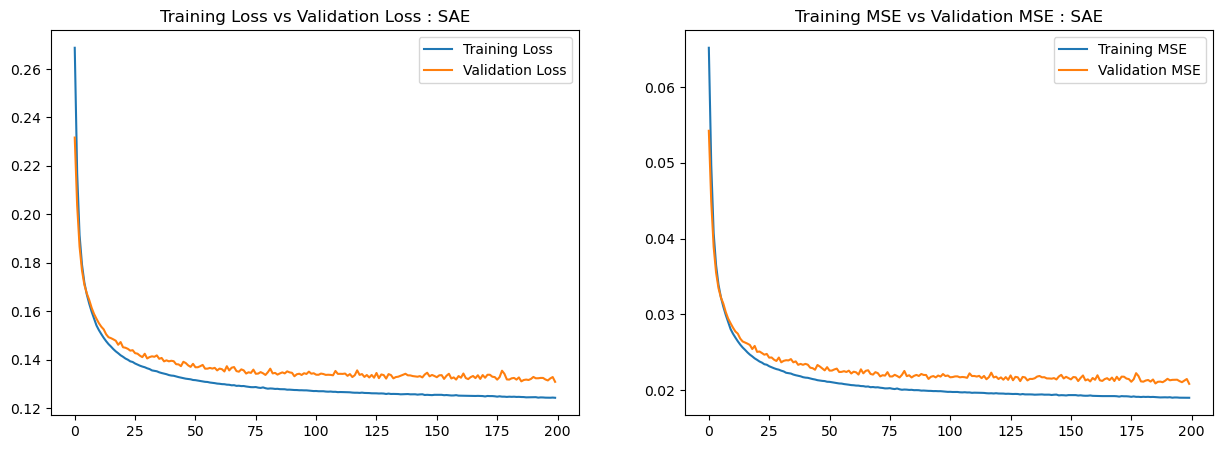

In [33]:
fig, axis = plt.subplots(nrows=1,ncols=2,figsize=(15,5))

axis[0].set_title("Training Loss vs Validation Loss : SAE")
axis[0].plot(hist["loss"], label = "Training Loss")
axis[0].plot(hist["val_loss"], label = "Validation Loss")
axis[0].legend()

axis[1].set_title("Training MSE vs Validation MSE : SAE")
axis[1].plot(hist["mse"], label = "Training MSE")
axis[1].plot(hist["val_mse"], label = "Validation MSE")
axis[1].legend()

### Predictions on Test Set

In [20]:
predictions = autoencoder.predict(noisy_pX_test.reshape(len(X_test),28*28))

313/313 [==============================] - 1s 1ms/step


### Displaying Original, Encoded and Decoded Representations for Training Set

* Original Image from MNIST Dataset
* Noisy Image
* Encoded Representation (32 dimensions)
* Decoded Representation

In [21]:
dec_X_train = autoencoder.predict(noisy_pX_train.reshape(len(X_train),28*28)) # decoded representations from autoencoder
enc_X_train = encoder.predict(noisy_pX_train.reshape(len(X_train),28*28))     # encoded representations from encoder

1875/1875 [==============================] - 2s 953us/step


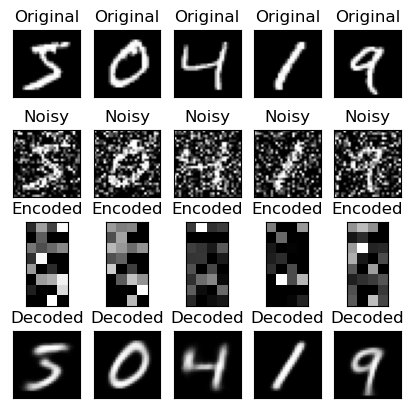

In [25]:
display(pX_train,noisy_pX_train,enc_X_train,dec_X_train);

### Displaying Original, Encoded and Decoded Representations for Test Set

* Original Image from MNIST Dataset
* Noisy Image
* Encoded Representation (32 dimensions)
* Decoded Representation

In [26]:
dec_X_test = autoencoder.predict(noisy_pX_test.reshape(len(X_test),784))  # decoded representations from autoencoder
enc_X_test = encoder.predict(noisy_pX_test.reshape(len(X_test),784))      # encoded representations from encoder

313/313 [==============================] - 0s 704us/step


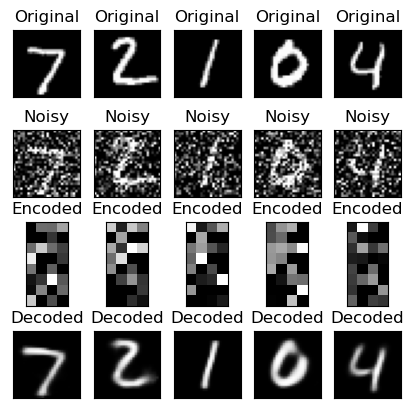

In [27]:
display(pX_test,noisy_pX_test,enc_X_test,dec_X_test);

313/313 [==============================] - 0s 1ms/step


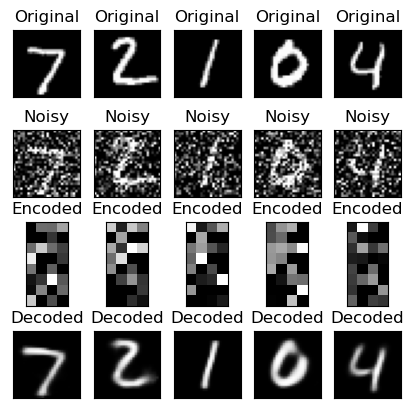

In [29]:
display(pX_test,noisy_pX_test,enc_X_test,decoder.predict(enc_X_test));

In [30]:
from keras.models import save_model

In [31]:
save_model(autoencoder,"autoencoder_sae.h5")
save_model(encoder,"encoder_sae.h5")
save_model(decoder,"decoder_sae.h5")

/var/folders/cj/hzdf62qj71sdyzsg2kpk9sdw0000gn/T/ipykernel_1333/408458525.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(autoencoder,"autoencoder_sae.h5")
/var/folders/cj/hzdf62qj71sdyzsg2kpk9sdw0000gn/T/ipykernel_1333/408458525.py:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(encoder,"encoder_sae.h5")
/var/folders/cj/hzdf62qj71sdyzsg2kpk9sdw0000gn/T/ipykernel_1333/408458525.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(decoder,"decoder_sae.h5")


In [32]:
hist.to_csv("sae_hist.csv",index=False)